In [41]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Import the dependencies 

In [48]:
pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import dependencies 
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, ParameterGrid, train_test_split

### Load and read the data

In [3]:
# File paths
sample_submission = Path("Resources/sample_submission.csv")
test_sequences = Path("Resources/test_sequences.csv")
train_labels = Path("Resources/train_labels.csv")
train_sequences = Path("Resources/train_sequences.csv")
validation_labels = Path("Resources/validation_labels.csv")
validation_sequences_path = Path("Resources/validation_sequences.csv")  # Rename variable

# Read CSV files into DataFrames
sample_submission_df = pd.read_csv(sample_submission)
test_sequences_df = pd.read_csv(test_sequences)
train_labels_df = pd.read_csv(train_labels)
train_sequences_df = pd.read_csv(train_sequences)
validation_labels_df = pd.read_csv(validation_labels)
validation_sequences_df = pd.read_csv(validation_sequences_path)  # Use renamed variable

# Display the first few rows of each DataFrame
print("Sample Submission DataFrame:")
print(sample_submission_df.head())

print("\nTest Sequences DataFrame:")
print(test_sequences_df.head())

print("\nTrain Labels DataFrame:")
print(train_labels_df.head())

print("\nTrain Sequences DataFrame:")
print(train_sequences_df.head())

print("\nValidation Labels DataFrame:")
print(validation_labels_df.head())

print("\nValidation Sequences DataFrame:")
print(validation_sequences_df.head())


Sample Submission DataFrame:
        ID resname  resid  x_1  y_1  z_1  x_2  y_2  z_2  x_3  y_3  z_3  x_4  \
0  R1107_1       G      1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  R1107_2       G      2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  R1107_3       G      3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  R1107_4       G      4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  R1107_5       G      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   y_4  z_4  x_5  y_5  z_5  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  

Test Sequences DataFrame:
  target_id                                           sequence  \
0     R1107  GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...   
1     R1108  GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...   
2     R1116  CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...   
3   R1117v2                    

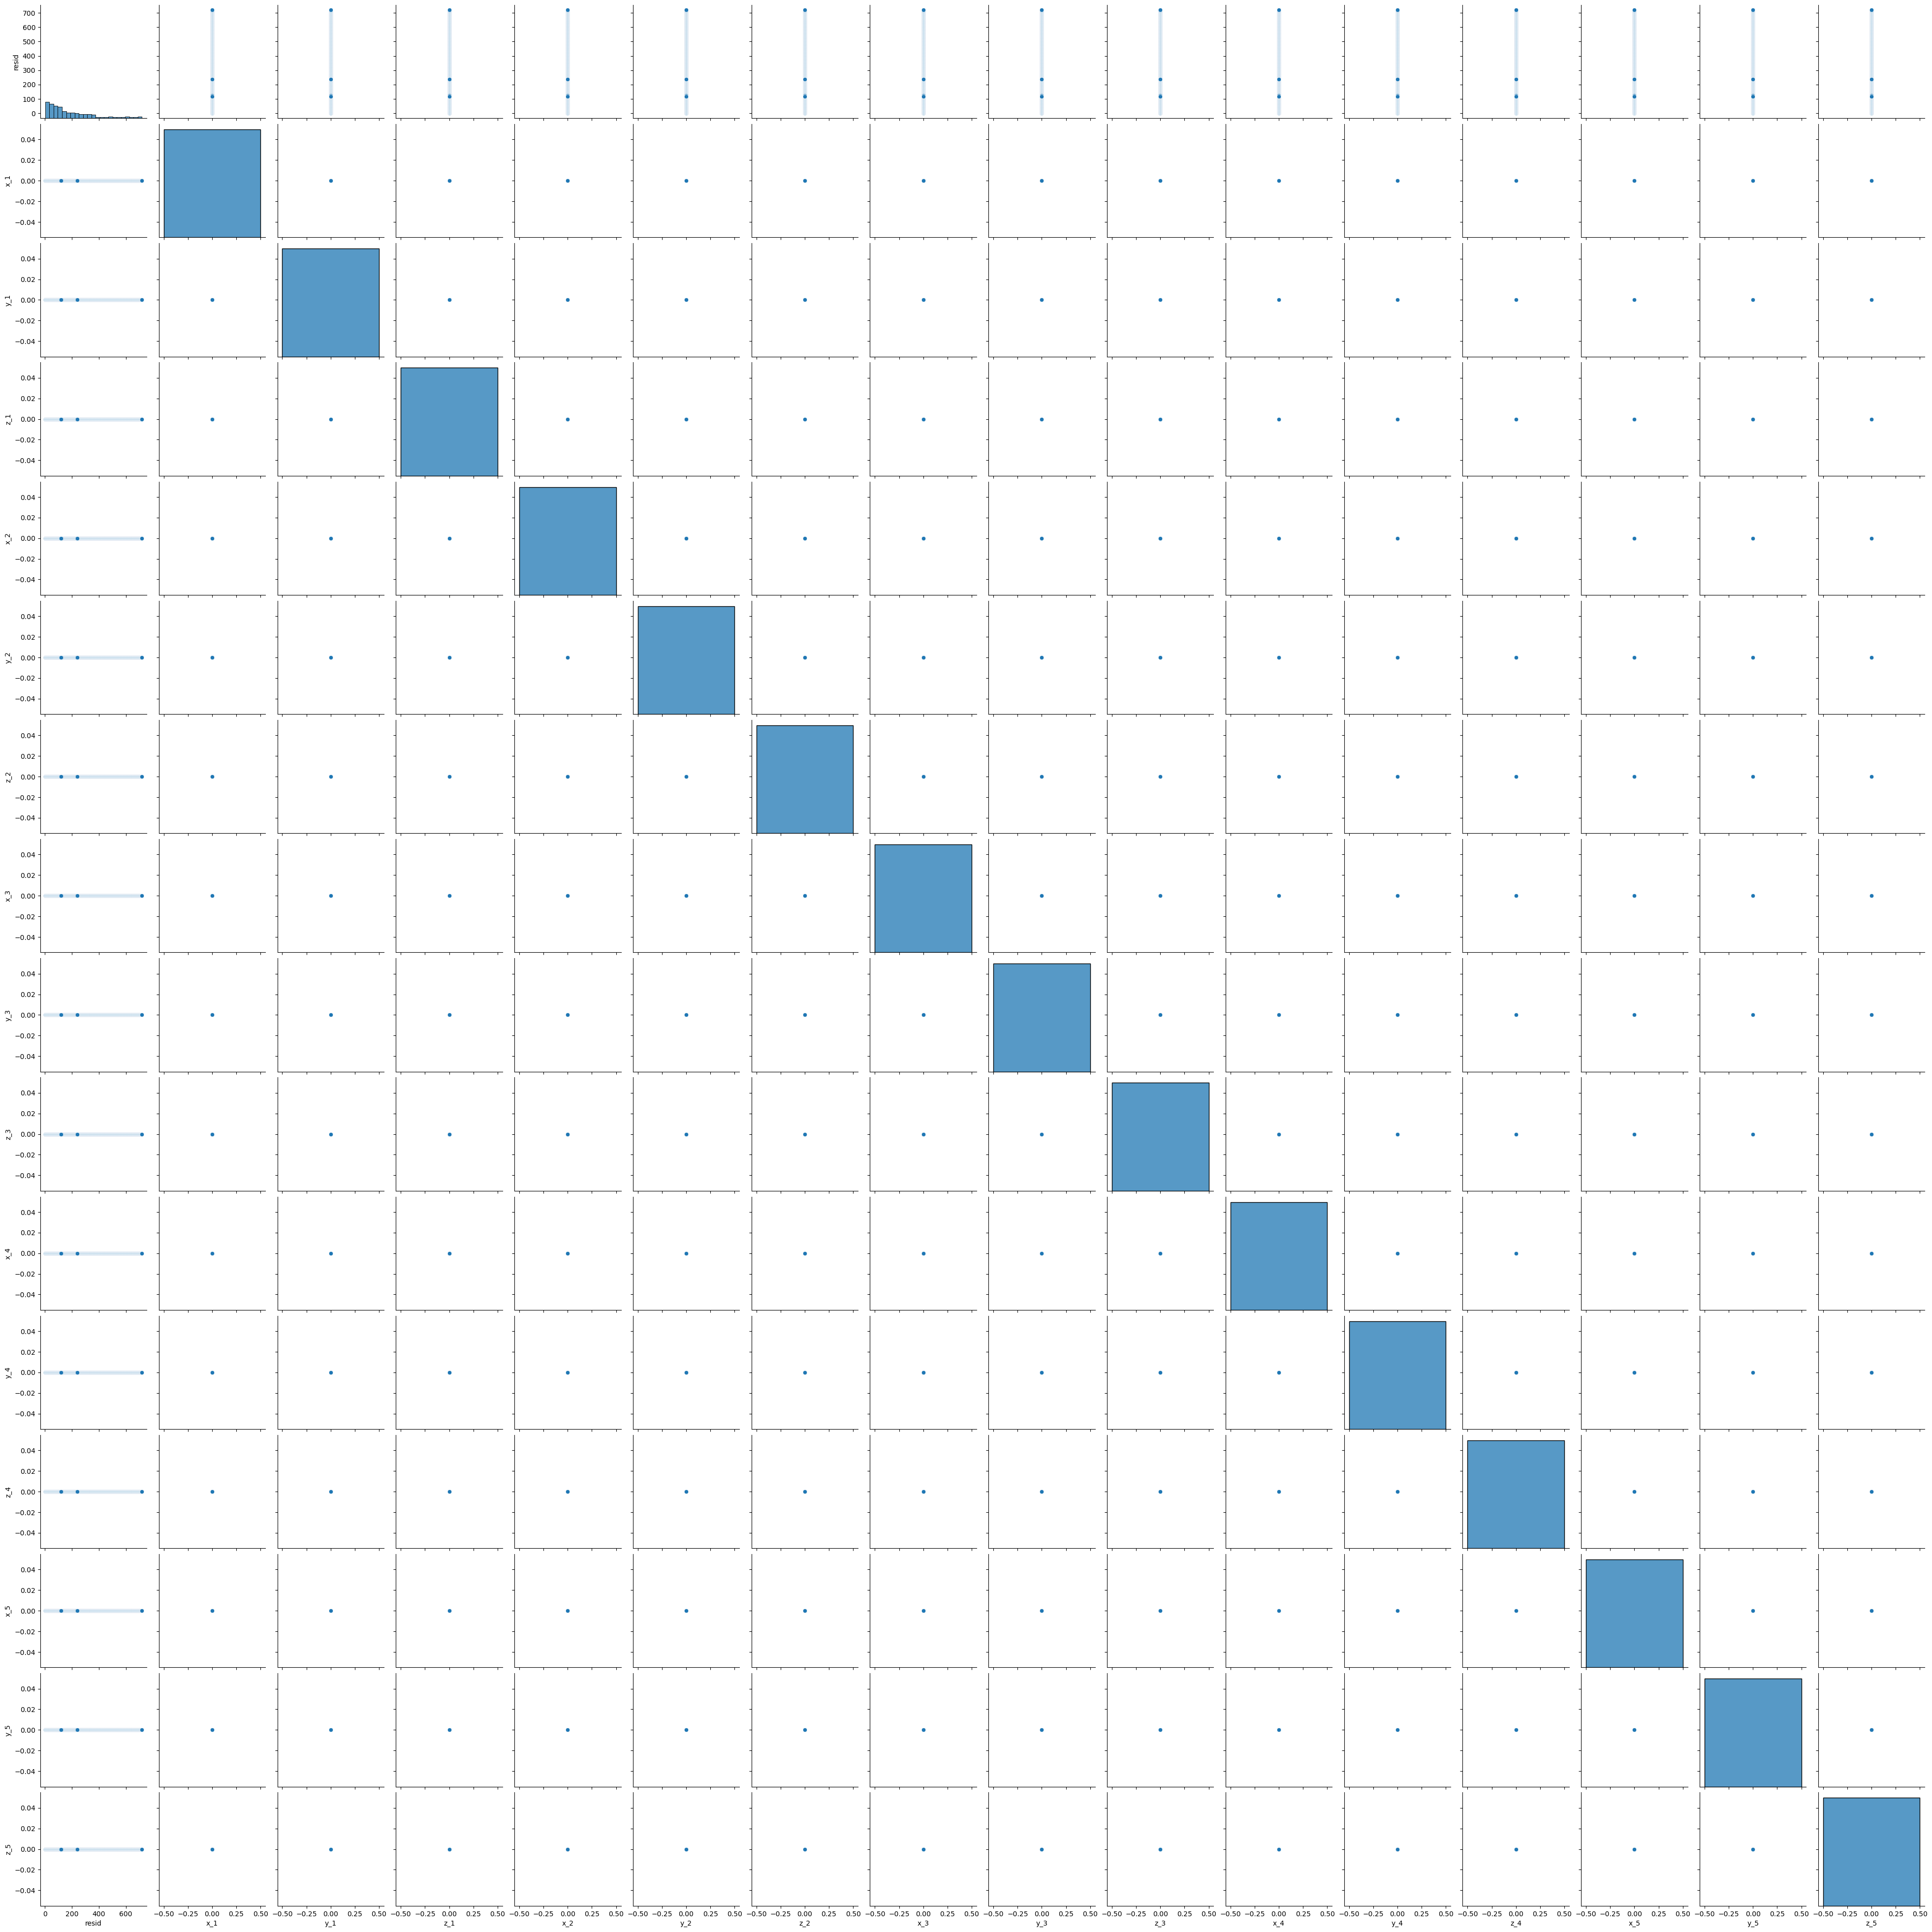

In [6]:
# Visualize pairwise relationships
sns.pairplot(sample_submission_df)
plt.show()


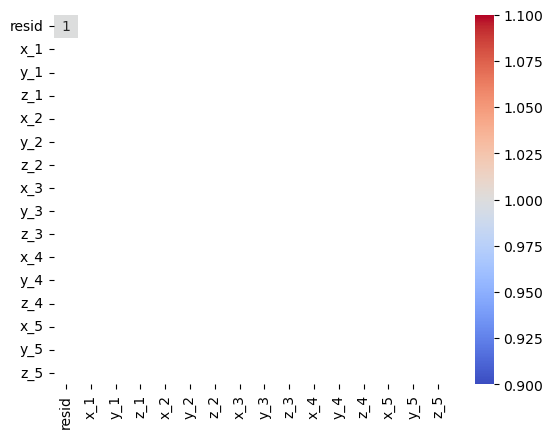

In [8]:
# Select only numeric columns for correlation analysis
numeric_data = sample_submission_df.select_dtypes(include=['float64', 'int64'])

# Generate the heatmap
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.show()



Merging the data

In [11]:
# Merge sequence and structural data based on target_id
merged_df = pd.merge(train_labels_df, train_sequences_df, left_on='ID', right_on='target_id', how='left')

# Display the first few rows of the merged DataFrame
merged_df.head()


,ID,resname,resid,x_1,y_1,z_1,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A_1,G,1,13.760,-25.974001,0.102,NaN,NaN,NaN,NaN,NaN
1,1SCL_A_2,G,2,9.310,-29.638000,2.669,NaN,NaN,NaN,NaN,NaN
2,1SCL_A_3,G,3,5.529,-27.813000,5.878,NaN,NaN,NaN,NaN,NaN
3,1SCL_A_4,U,4,2.678,-24.900999,9.793,NaN,NaN,NaN,NaN,NaN
4,1SCL_A_5,G,5,1.827,-20.136000,11.793,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

Failed file

In [15]:
# Fill missing values
merged_df.fillna('', inplace=True)

# Clean and preprocess the sequences
merged_df['sequence'] = merged_df['sequence'].str.strip().str.replace('\n', '')

# Normalize coordinate data
scaler = StandardScaler()
merged_df[['x_1', 'y_1', 'z_1']] = scaler.fit_transform(merged_df[['x_1', 'y_1', 'z_1']])

# Display the first few rows of the processed DataFrame
print(merged_df.head())


/var/folders/pq/m0qzt3d55l39kx3nwyjhkt8w0000gn/T/ipykernel_4826/816950566.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna('', inplace=True)


ValueError: could not convert string to float: ''

In [17]:
# Check for non-numeric values in the coordinate columns
print(merged_df[['x_1', 'y_1', 'z_1']].applymap(lambda x: isinstance(x, (int, float))))



          x_1    y_1    z_1
0        True   True   True
1        True   True   True
2        True   True   True
3        True   True   True
4        True   True   True
...       ...    ...    ...
137090  False  False  False
137091  False  False  False
137092  False  False  False
137093  False  False  False
137094  False  False  False

[137095 rows x 3 columns]


/var/folders/pq/m0qzt3d55l39kx3nwyjhkt8w0000gn/T/ipykernel_4826/1376466223.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(merged_df[['x_1', 'y_1', 'z_1']].applymap(lambda x: isinstance(x, (int, float))))


# After the above code failed

In [20]:
# Replace non-numeric values with NaN
merged_df[['x_1', 'y_1', 'z_1']] = merged_df[['x_1', 'y_1', 'z_1']].apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the mean of their respective columns
merged_df['x_1'].fillna(merged_df['x_1'].mean(), inplace=True)
merged_df['y_1'].fillna(merged_df['y_1'].mean(), inplace=True)
merged_df['z_1'].fillna(merged_df['z_1'].mean(), inplace=True)

# Normalize coordinate data
scaler = StandardScaler()
merged_df[['x_1', 'y_1', 'z_1']] = scaler.fit_transform(merged_df[['x_1', 'y_1', 'z_1']])

# Display the cleaned DataFrame
print(merged_df.head())


         ID resname  resid       x_1       y_1       z_1 target_id sequence  \
0  1SCL_A_1       G      1 -0.462849 -0.979448 -0.844099                      
1  1SCL_A_2       G      2 -0.493735 -1.012068 -0.822103                      
2  1SCL_A_3       G      3 -0.519977 -0.995820 -0.794606                      
3  1SCL_A_4       U      4 -0.539765 -0.969895 -0.761060                      
4  1SCL_A_5       G      5 -0.545671 -0.927473 -0.743922                      

  temporal_cutoff description all_sequences  
0                                            
1                                            
2                                            
3                                            
4                                            


/var/folders/pq/m0qzt3d55l39kx3nwyjhkt8w0000gn/T/ipykernel_4826/3663280842.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['x_1'].fillna(merged_df['x_1'].mean(), inplace=True)
/var/folders/pq/m0qzt3d55l39kx3nwyjhkt8w0000gn/T/ipykernel_4826/3663280842.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

# creating targets with the same shape

In [23]:
# Dummy example: Creating targets with the same shape as input data
data = {}  # Initialize a dictionary to hold data (assuming a PyTorch-Geometric Data object later)
data['y'] = torch.tensor(merged_df[['x_1', 'y_1', 'z_1']].values, dtype=torch.float)

# Display the tensor to verify
print(data['y'])


tensor([[-4.6285e-01, -9.7945e-01, -8.4410e-01],
        [-4.9374e-01, -1.0121e+00, -8.2210e-01],
        [-5.1998e-01, -9.9582e-01, -7.9461e-01],
        ...,
        [-9.8632e-17,  0.0000e+00,  1.2177e-16],
        [-9.8632e-17,  0.0000e+00,  1.2177e-16],
        [-9.8632e-17,  0.0000e+00,  1.2177e-16]])


# Define a GNN Model

In [26]:
# Convert merged DataFrame to a tensor
x = torch.tensor(merged_df[['x_1', 'y_1', 'z_1']].values, dtype=torch.float)
y = torch.tensor(merged_df[['x_1', 'y_1', 'z_1']].values, dtype=torch.float)

# Define dummy edge_index for this example
edge_index = torch.tensor([[0, 1], [1, 2]], dtype=torch.long)  # Placeholder

# Create a Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define an enhanced GNN model with more layers and dropout
class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(EnhancedGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)  # Apply dropout
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x

# Split the data into train, validation, and test sets
X = data.x.numpy()
y = data.y.numpy()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to torch tensors
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=data.edge_index, y=torch.tensor(y_train, dtype=torch.float))
val_data = Data(x=torch.tensor(X_val, dtype=torch.float), edge_index=data.edge_index, y=torch.tensor(y_val, dtype=torch.float))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=data.edge_index, y=torch.tensor(y_test, dtype=torch.float))

# Hyperparameter tuning
num_epochs = 100
patience = 10
best_r2 = float('-inf')
best_params = {}

param_grid = {
    'learning_rate': [0.001, 0.005, 0.01],
    'hidden_dim': [16, 32],
    'dropout_rate': [0.3, 0.5]
}

# DataFrame to store results
results_df = pd.DataFrame(columns=['learning_rate', 'hidden_dim', 'dropout_rate', 'training_loss', 'validation_loss', 'mae', 'r2'])

print("Starting hyperparameter tuning...")

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = EnhancedGNN(input_dim=3, hidden_dim=params['hidden_dim'], output_dim=3, dropout_rate=params['dropout_rate'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Calculate metrics
    model.eval()
    with torch.no_grad():
        final_out = model(val_data)
        mae = mean_absolute_error(val_data.y.detach().numpy(), final_out.detach().numpy())
        r2 = r2_score(val_data.y.detach().numpy(), final_out.detach().numpy())
        print(f"R² Score: {r2:.4f}, MAE: {mae:.4f}")

        # Record results
        new_row = pd.DataFrame([{
            'learning_rate': params['learning_rate'],
            'hidden_dim': params['hidden_dim'],
            'dropout_rate': params['dropout_rate'],
            'training_loss': loss.item(),
            'validation_loss': val_loss.item(),
            'mae': mae,
            'r2': r2
        }])
        results_df = pd.concat([results_df, new_row], ignore_index=True)

        if r2 > best_r2:
            best_r2 = r2
            best_params = params

# Save results to CSV
results_df.to_csv('model_optimization_results.csv', index=False)

Starting hyperparameter tuning...
Testing parameters: {'dropout_rate': 0.3, 'hidden_dim': 16, 'learning_rate': 0.001}
Epoch 1/100, Training Loss: 1.0453894138336182, Validation Loss: 0.9962837100028992
Epoch 2/100, Training Loss: 1.0299867391586304, Validation Loss: 0.9817377924919128
Epoch 3/100, Training Loss: 1.011953592300415, Validation Loss: 0.9674208760261536
Epoch 4/100, Training Loss: 1.0011566877365112, Validation Loss: 0.9533292055130005
Epoch 5/100, Training Loss: 0.9853573441505432, Validation Loss: 0.9394527673721313
Epoch 6/100, Training Loss: 0.9734222292900085, Validation Loss: 0.925784170627594
Epoch 7/100, Training Loss: 0.9606046676635742, Validation Loss: 0.9123210906982422
Epoch 8/100, Training Loss: 0.9460705518722534, Validation Loss: 0.8990572690963745
Epoch 9/100, Training Loss: 0.9345507025718689, Validation Loss: 0.8859871625900269
Epoch 10/100, Training Loss: 0.9207971692085266, Validation Loss: 0.8731099367141724
Epoch 11/100, Training Loss: 0.906152307987

/var/folders/pq/m0qzt3d55l39kx3nwyjhkt8w0000gn/T/ipykernel_4826/1957935757.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch 1/100, Training Loss: 1.5760490894317627, Validation Loss: 1.3889212608337402
Epoch 2/100, Training Loss: 1.4565647840499878, Validation Loss: 1.28983736038208
Epoch 3/100, Training Loss: 1.348681092262268, Validation Loss: 1.2008270025253296
Epoch 4/100, Training Loss: 1.2555184364318848, Validation Loss: 1.1204980611801147
Epoch 5/100, Training Loss: 1.1712498664855957, Validation Loss: 1.047957181930542
Epoch 6/100, Training Loss: 1.0952948331832886, Validation Loss: 0.982769787311554
Epoch 7/100, Training Loss: 1.0293368101119995, Validation Loss: 0.9243015050888062
Epoch 8/100, Training Loss: 0.9702360033988953, Validation Loss: 0.8725637793540955
Epoch 9/100, Training Loss: 0.9194204807281494, Validation Loss: 0.8280090093612671
Epoch 10/100, Training Loss: 0.8736321330070496, Validation Loss: 0.7892374396324158
Epoch 11/100, Training Loss: 0.8306469321250916, Validation Loss: 0.7537121176719666
Epoch 12/100, Training Loss: 0.7906252145767212, Validation Loss: 0.72003728151

In [28]:
# Define an enhanced GNN model with more layers, dropout, and batch normalization
class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(EnhancedGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.conv3 = pyg_nn.GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.bn1(x)  # Apply batch normalization
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)  # Apply batch normalization
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# Hyperparameter tuning remains the same, but consider expanding the grid
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.005, 0.01],
    'hidden_dim': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7]
}

In [30]:
# After calculating metrics
model.eval()
with torch.no_grad():
    final_out = model(val_data)
    mae = mean_absolute_error(val_data.y.detach().numpy(), final_out.detach().numpy())
    r2 = r2_score(val_data.y.detach().numpy(), final_out.detach().numpy())
    
    # Print R² and MAE
    print(f"R² Score: {r2:.4f}, MAE: {mae:.4f}")

R² Score: 0.9621, MAE: 0.1397


In [32]:
    # Record results
    new_row = pd.DataFrame([{
        'learning_rate': params['learning_rate'],
        'hidden_dim': params['hidden_dim'],
        'dropout_rate': params['dropout_rate'],
        'training_loss': loss.item(),
        'validation_loss': val_loss.item(),
        'mae': mae,
        'r2': r2
    }])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    if r2 > best_r2:
        best_r2 = r2
        best_params = params

# Feature Importance
To analyze feature importance, we’ll use a Random Forest model and calculate the importance of each feature.

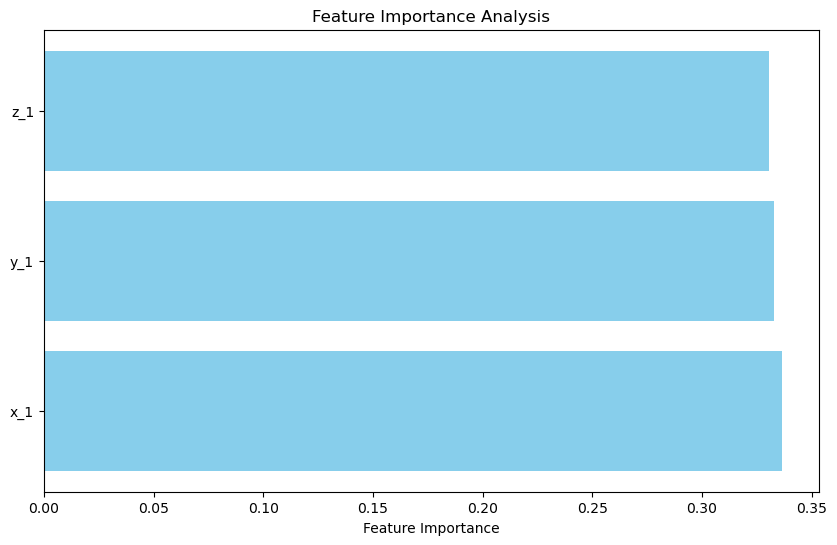

In [35]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Prepare data
X = train_labels_df[['x_1', 'y_1', 'z_1']]  # Features
y = train_labels_df['resid']  # Target variable

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

 # Cross-Validation
Implementing k-fold cross-validation:

# This code will take long to run

In [ ]:
# Define K-Fold cross-validation
num_folds = 5  # You can adjust this number
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# DataFrame to store results
results_df = pd.DataFrame(columns=['learning_rate', 'hidden_dim', 'dropout_rate', 'fold', 'mae', 'r2'])

print("Starting hyperparameter tuning with cross-validation...")

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{num_folds}")
        
        # Split the data into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Convert to torch tensors
        train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=data.edge_index, y=torch.tensor(y_train, dtype=torch.float))
        val_data = Data(x=torch.tensor(X_val, dtype=torch.float), edge_index=data.edge_index, y=torch.tensor(y_val, dtype=torch.float))
        
        # Initialize model, optimizer, and loss function
        model = EnhancedGNN(input_dim=3, hidden_dim=params['hidden_dim'], output_dim=3, dropout_rate=params['dropout_rate'])
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.MSELoss()
        
        best_val_loss = float('inf')
        patience_counter = 0
        num_epochs = 100
        patience = 10  # Early stopping patience

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(train_data)
            loss = criterion(out, train_data.y)
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_out = model(val_data)
                val_loss = criterion(val_out, val_data.y)

            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break
        
        # Calculate metrics
        model.eval()
        with torch.no_grad():
            final_out = model(val_data)
            mae = mean_absolute_error(val_data.y.detach().numpy(), final_out.detach().numpy())
            r2 = r2_score(val_data.y.detach().numpy(), final_out.detach().numpy())
            print(f"Fold {fold + 1} - R² Score: {r2:.4f}, MAE: {mae:.4f}")

            # Record results for this fold
            fold_results.append({
                'learning_rate': params['learning_rate'],
                'hidden_dim': params['hidden_dim'],
                'dropout_rate': params['dropout_rate'],
                'fold': fold + 1,
                'mae': mae,
                'r2': r2
            })
    
    # Append fold results to the main results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(fold_results)], ignore_index=True)


Starting hyperparameter tuning with cross-validation...
Testing parameters: {'dropout_rate': 0.3, 'hidden_dim': 16, 'learning_rate': 0.0001}
Fold 1/5
Epoch 1/100, Training Loss: 3.410334825515747, Validation Loss: 1.1759902238845825
Epoch 2/100, Training Loss: 3.3986244201660156, Validation Loss: 1.1769917011260986
Epoch 3/100, Training Loss: 3.406024694442749, Validation Loss: 1.178821086883545
Epoch 4/100, Training Loss: 3.395573854446411, Validation Loss: 1.1819347143173218
Epoch 5/100, Training Loss: 3.3998239040374756, Validation Loss: 1.1861494779586792
Epoch 6/100, Training Loss: 3.3975603580474854, Validation Loss: 1.192132830619812
Epoch 7/100, Training Loss: 3.373955249786377, Validation Loss: 1.199785590171814
Epoch 8/100, Training Loss: 3.349022388458252, Validation Loss: 1.2082326412200928
Epoch 9/100, Training Loss: 3.3579599857330322, Validation Loss: 1.2180253267288208
Epoch 10/100, Training Loss: 3.359424591064453, Validation Loss: 1.2290663719177246
Epoch 11/100, Trai

/var/folders/pq/m0qzt3d55l39kx3nwyjhkt8w0000gn/T/ipykernel_3782/307796953.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(fold_results)], ignore_index=True)


Epoch 2/100, Training Loss: 4.089198112487793, Validation Loss: 1.194067358970642
Epoch 3/100, Training Loss: 3.9819087982177734, Validation Loss: 1.1708908081054688
Epoch 4/100, Training Loss: 3.887348175048828, Validation Loss: 1.1542677879333496
Epoch 5/100, Training Loss: 3.807406187057495, Validation Loss: 1.1411253213882446
Epoch 6/100, Training Loss: 3.7114295959472656, Validation Loss: 1.1301729679107666
Epoch 7/100, Training Loss: 3.6342813968658447, Validation Loss: 1.120473027229309
Epoch 8/100, Training Loss: 3.534810781478882, Validation Loss: 1.111057996749878
Epoch 9/100, Training Loss: 3.4672884941101074, Validation Loss: 1.1017533540725708
Epoch 10/100, Training Loss: 3.3459291458129883, Validation Loss: 1.0922443866729736
Epoch 11/100, Training Loss: 3.2959585189819336, Validation Loss: 1.0825334787368774
Epoch 12/100, Training Loss: 3.2150280475616455, Validation Loss: 1.0722017288208008
Epoch 13/100, Training Loss: 3.1452856063842773, Validation Loss: 1.061232924461

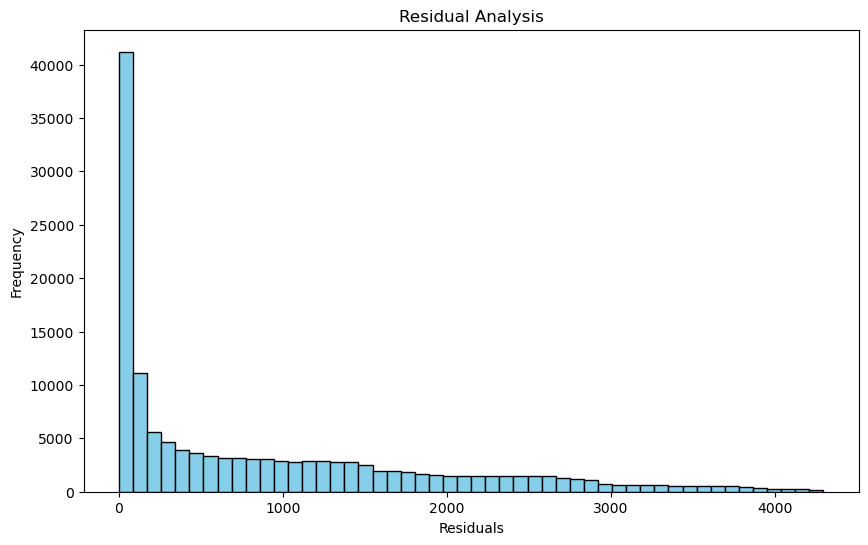

In [66]:
# Dummy data for GNN model (use your actual model data)
import numpy as np
val_predictions = np.random.rand(len(y))  # Replace with actual model predictions

# Calculate residuals
residuals = y - val_predictions

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Analysis')
plt.show()


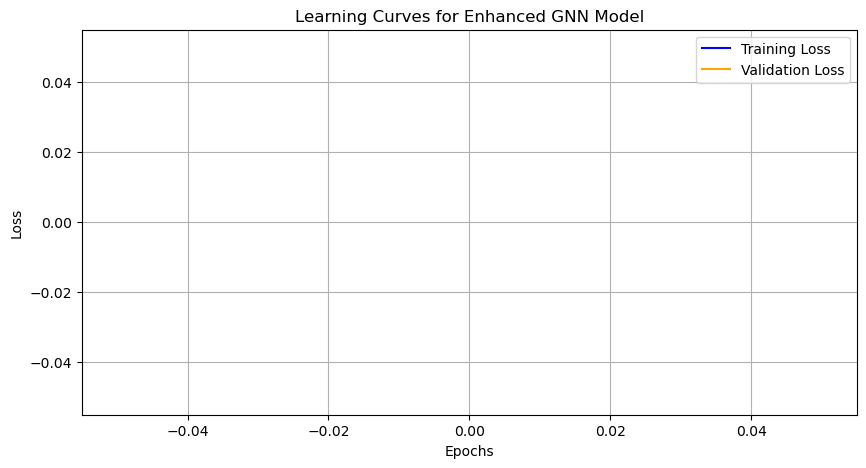

In [68]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves for Enhanced GNN Model')
plt.legend()
plt.grid(True)
plt.show()

# different model

In [42]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Initialize the XGBoost regressor
model = XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
#If You Are Performing Classification
#If your target variable is categorical and you want to classify it, ensure that y_train and y_test contain discrete class labels. Here’s how to do it with XGBClassifier:

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

Mean Squared Error: 0.00022640528914052993


We are not going to use XGBOOST Model because the R2 is 0.0002